# Spatial Error Model + Regimes

In [1]:
from esda.moran import Moran
import geopandas as gpd
from libpysal.weights import DistanceBand, KNN
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from splot.esda import plot_moran
import spreg
import sys

sys.path.append("..")
from statshelper import q_q_plot
plt.style.use('dark_background')

In [2]:
df = pd.read_csv("../data/processed/Cleaned_Chicago_Sales.csv")
df.head()

,Unnamed: 0,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,...,Bool-Type of Residence-1,Bool-Type of Residence-2,Bool-Type of Residence-4,Bool-Type of Residence-8,Bool-Type of Residence-7,Bool-Type of Residence-6,Bool-Wall Material-2,Bool-Wall Material-3,Bool-Wall Material-1,Bool-Wall Material-4
0,2,16094150130000,211,13,-0.297580,77,3.0,6.0,2.0,2.0,...,0,0,0,0,0,0,1,0,0,0
1,5,4252000820000,204,100,2.868180,25,5.0,0.0,2.0,4.0,...,0,0,0,0,0,0,1,0,0,0
2,8,14322110150000,208,12,-0.596010,74,3.0,0.0,2.0,6.0,...,0,0,0,0,0,0,1,0,0,0
3,9,27021200080000,204,34,1.698873,28,1.0,0.0,3.0,1.0,...,1,0,0,0,0,0,0,1,0,0
4,11,13121080620000,204,42,0.515768,71,1.0,0.0,2.0,1.0,...,1,0,0,0,0,0,1,0,0,0


We read the data into a Dataframe and then transform it into a GeoDataFrame which is then projected to UTM 16N.

In [3]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:26916")

The regimes model requires that you have a certain number of points in each regime. For our regimes, we are using the `Town Code` which is provided by the dataset.

In [4]:
print(gdf["Town Code"].value_counts())

72    39335
71    34707
77    20515
70    18213
37    14126
31    13102
39    11337
38    11312
22    10142
13     9741
35     9316
18     8934
73     8721
29     8668
21     8660
32     8208
28     7623
12     7555
24     7389
25     7201
20     6782
23     6368
16     5002
11     4819
15     4334
76     4044
27     4022
17     3979
30     3537
36     3182
26     2218
74     2083
75     2080
19     1877
10     1626
34     1591
33     1007
14      905
Name: Town Code, dtype: int64


This is a common set of quantitiative variables shared across all of these models. We take a random sample of size 2.5% and ensure that it is the same 8,107 data points by seeding the random number generator with `random_state=0`.

In [5]:
i_vars = [
    'Age',
    'Bedrooms',  
    'Building Square Feet', 
    'Estimate (Building)', 
    'Estimate (Land)', 
    'Fireplaces', 
    'Full Baths',
    'Garage 1 Area',
    'Garage 2 Area', 
    'Half Baths', 
    'Land Square Feet',
    'Rooms',
    'Sale Quarter'
    ]
dep_var = ['Sale Price']
other_to_keep = ["PIN", "Neighborhood Code", "Town Code", "geometry"]
my_rows = i_vars+dep_var+other_to_keep
gdf = gdf[my_rows]
gdf = gdf.sample(frac=.025, random_state=0)
print("Dataframe has {} rows and {} columns".format(len(gdf), len(list(gdf.columns))))
X = gdf[i_vars].values
y = gdf[dep_var].values.ravel()
gdf.head()

Dataframe has 8107 rows and 18 columns


,Age,Bedrooms,Building Square Feet,Estimate (Building),Estimate (Land),Fireplaces,Full Baths,Garage 1 Area,Garage 2 Area,Half Baths,Land Square Feet,Rooms,Sale Quarter,Sale Price,PIN,Neighborhood Code,Town Code,geometry
255476,-1.090298,-0.292681,-0.780196,-0.213234,-0.668786,-0.599533,-0.891279,-2.100215,-0.041762,1.066654,0.082893,-0.268846,-1.233509,-0.213048,27272130250000,46,28,POINT (430474.445 4604029.943)
4525,-0.771854,-0.292681,-0.318133,-0.419435,-1.613855,-0.599533,-0.891279,-2.100215,-0.041762,1.066654,-2.396135,-0.268846,-0.983113,-1.020361,7072031870000,109,35,POINT (406403.875 4657100.302)
206728,-0.899231,2.583133,2.016681,0.949160,0.117826,-0.599533,2.162552,-2.100215,-0.041762,-0.848209,0.955862,2.906338,0.769658,0.771894,28314100050000,210,13,POINT (435165.992 4601377.469)
251208,-0.453411,-0.292681,-0.731985,0.374207,-0.133190,-0.599533,-0.891279,0.550000,-0.041762,-0.848209,-0.596010,-0.795788,-1.358707,-0.086441,12124070110000,10,26,POINT (432372.275 4647115.837)
172553,0.215320,-0.292681,-0.772410,-0.961504,-0.131889,-0.599533,-0.891279,-2.100215,-0.041762,-0.848209,0.302863,-0.795788,-1.483905,-1.267365,23142080080000,12,30,POINT (431836.962 4616704.122)


Create the spatial weight matrix using k-nearest neighbors with K=64.

In [6]:
# determine weight matrix
w = KNN.from_dataframe(gdf, k=64) # needed k large enough that it was connected
#w = DistanceBand.from_dataframe(gdf,threshold=.0075) # needed k large enough that it was connected

Transform the weight matrix to normalize by rows.

In [7]:
w.transform = 'R'

In the code below we are calculating the Spatial Error Model with Regimes, allowing the intercept to vary across regimes, but not other variables (this is controlled by `cols2regi` argument). 

In [8]:
rsem = spreg.ML_Error_Regimes(y, X, w=w,
                            regimes=list(gdf["Town Code"]),
                            name_x=i_vars, name_y="Sale Price", 
                            cols2regi=[False]*len(i_vars))

/home/lagrange/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:777: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [9]:
print(rsem.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR - REGIMES (METHOD = full)
-----------------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  Sale Price                Number of Observations:        8107
Mean dependent var  :     -0.0035                Number of Variables   :          51
S.D. dependent var  :      0.9999                Degrees of Freedom    :        8056
Pseudo R-squared    :      0.4692
Sigma-square ML     :       0.315                Log likelihood        :   -5590.303
S.E of regression   :       0.561                Akaike info criterion :   11282.607
                                                 Schwarz criterion     :   11639.631

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------

Looking at the model fit:

* The $R^{2}$ of 0.47 is the lowest of all of the models meaning that only 47% of the variation in `Sales Price` can be explained by the model.
* The AIC of 11,282 is the lowest among all of the models, which is quite impressive!

We will look at the residuals first and then dive into the varied intercepts.

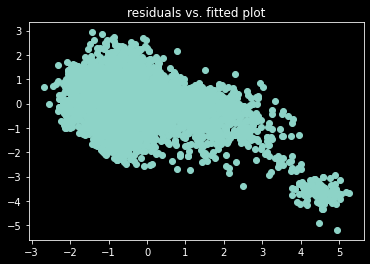

In [10]:
plt.scatter(rsem.predy, rsem.u)
plt.title("residuals vs. fitted plot")
plt.show()

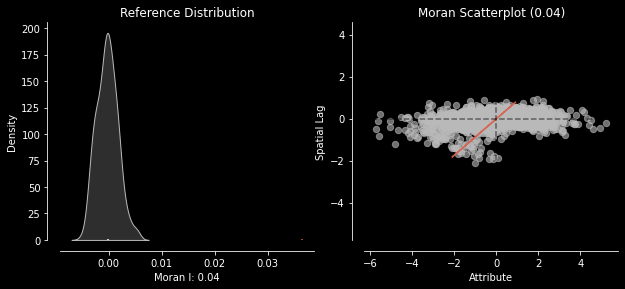

In [11]:
rsem_moran = Moran(rsem.e_filtered, w, permutations=199)
plot_moran(rsem_moran, zstandard=True, figsize=(10,4))
plt.show()

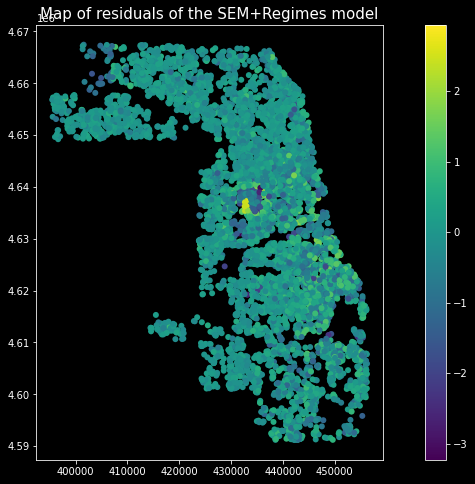

In [12]:
ax = gdf.plot(column=rsem.e_filtered.reshape(-1),legend=True,figsize=(15,8), linewidth=0.0)
plt.title("Map of residuals of the SEM+Regimes model",fontsize=15)
plt.show()

The Moran's I of 0.04 is pretty good, but notably worse than the SEM's Moran's I of 0.00. In the cell below we are copying the model's intercept for each town to the geodataframe.

In [13]:
# trying to get it so we can plot based on town code beta
town_codes = sorted(list(set(gdf["Town Code"])))
gdf_town_codes = list(gdf["Town Code"])
regime_betas = [ rsem.betas[town_codes.index(code), 0] for code in gdf_town_codes ]
gdf["SEMRegimeBeta"] = regime_betas

In the cell below you can see the intercept as it varies across our regimes (`Town Codes`). The bright yellow dot in the middle of the county is Oak Park which indicates that the location is highly desirable even when controlling for attributes of the house like the number of bedrooms, etc. However, it is important to determine which of these intercepts are statistically significant which we will do in the next map. 

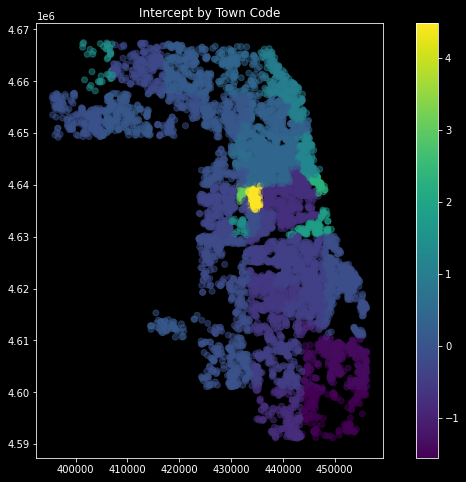

In [14]:
cmap=matplotlib.cm.viridis
norm=matplotlib.colors.Normalize(vmin=min(gdf["SEMRegimeBeta"]), vmax=max(gdf["SEMRegimeBeta"]))
ax = gdf.plot(column="SEMRegimeBeta", legend=True, figsize=(12,8), alpha=0.5, cmap=cmap, norm=norm)
plt.title("Intercept by Town Code")
plt.show()

In [15]:
# trying to get it so we can plot based on town code beta
town_codes = sorted(list(set(gdf["Town Code"])))
gdf_town_codes = list(gdf["Town Code"])
regime_betas = [ float(rsem.betas[town_codes.index(code), 0]) if rsem.z_stat[town_codes.index(code)][1] < 0.05 else float('inf') for code in gdf_town_codes ]
gdf["SEMRegimeBetaIfSig"] = regime_betas

Most of the intercepts are not statistically significant. Downtown Chicago to Oak Park do have statistically significant intercepts as well as a town in the south-east part of Cook County.

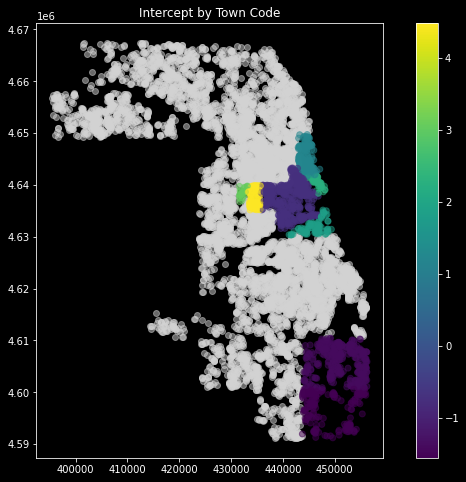

In [16]:
has_data = gdf[gdf["SEMRegimeBetaIfSig"] != float('inf')]
no_data = gdf[gdf["SEMRegimeBetaIfSig"] == float('inf')]
ax = no_data.plot(color='lightgrey', alpha=0.5, figsize=(12,8))
ax = has_data.plot(column="SEMRegimeBetaIfSig", categorical=False, legend=True, alpha=0.5, ax=ax, cmap=cmap, norm=norm)
plt.title("Intercept by Town Code")
plt.show()